AI group project <br>
Team No.: 10 <br>
Members: Shubhajeet Das (24AI10013) , Banala Sai Chandan (24AI10011), Aaron Jason Baptist (24AI10015) <br>
<b>Topic:</b> Predicting box office collection from IMDb dataset <br>
Following things are done here: <br>
<ol>
  <li> Scraping IMDb website for data
  <li> Visualising data
  <li> Data preprocessing
  <li> Predictive model
  <li> Conclusion
</ol>

# 1. Scraping IMDb website for data

I went to IMDb website and then in advanced search section, I applied the filter: Title type: Movie, country: India, languages: Hindi. <br>
Then I scraped using API. This is shown in a separate file titled "scraping.ipynb". <br>
Also I have adjusted box office collection values using consumer price index (CPI) values from RBI website.

# 2. Visualising data

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('movie.csv', parse_dates=['Release Date'])
data = df[df['Box Office (Cr.)'].notna() & df['Release Date'].notna() & df['rating'].notna()]
data['Box_office_adjusted'] = data['Box_office_adjusted'].fillna(data['Box Office (Cr.)'])

<ipython-input-1-7cf1220bdaf8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Box_office_adjusted'] = data['Box_office_adjusted'].fillna(data['Box Office (Cr.)'])


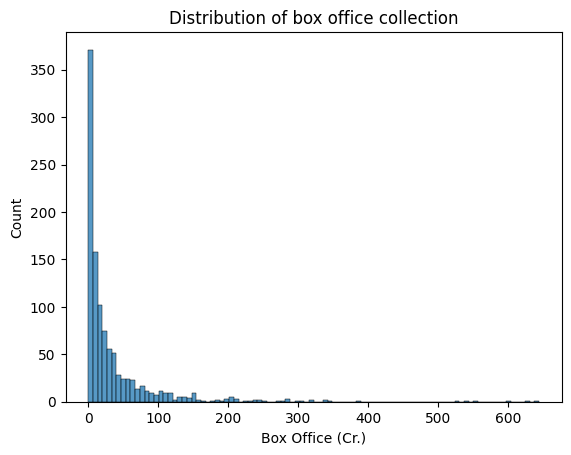

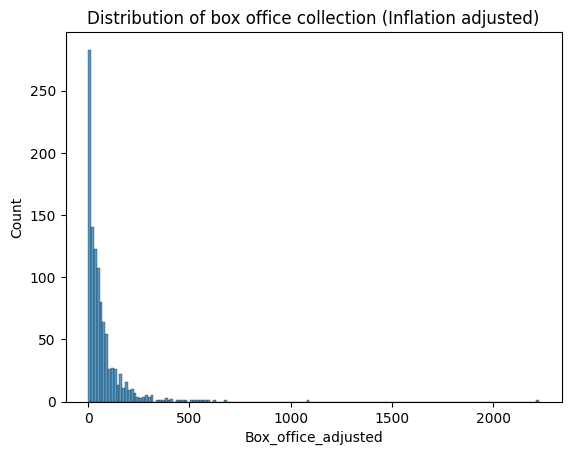

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data['Box Office (Cr.)'])
plt.title('Distribution of box office collection')
plt.show()
sns.histplot(data['Box_office_adjusted'])
plt.title('Distribution of box office collection (Inflation adjusted)')
plt.show()

The distribution feels skewed, so let us consider log of box office collection as the target parameter.

<ipython-input-3-892395897955>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['box_office_log'] = np.log1p(data['Box Office (Cr.)'])
<ipython-input-3-892395897955>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['box_office_adj_log'] = np.log1p(data['Box_office_adjusted'])


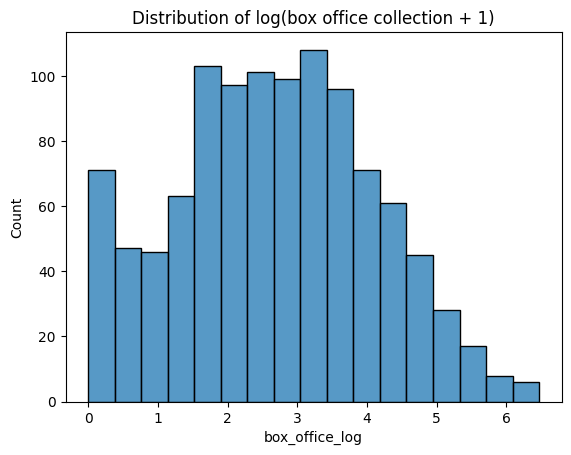

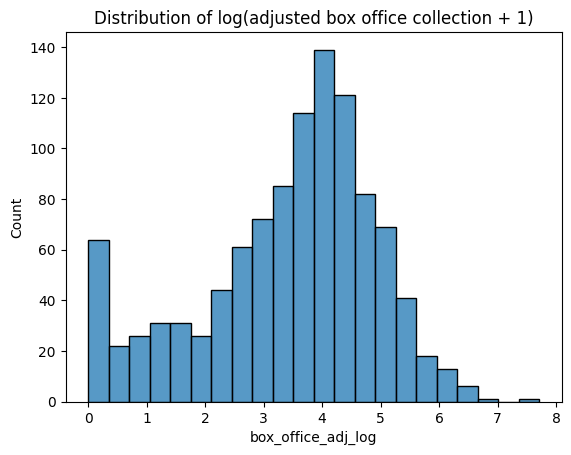

In [3]:
import numpy as np
data['box_office_log'] = np.log1p(data['Box Office (Cr.)'])
data['box_office_adj_log'] = np.log1p(data['Box_office_adjusted'])
sns.histplot(data['box_office_log'])
plt.title('Distribution of log(box office collection + 1)')
plt.show()
sns.histplot(data['box_office_adj_log'])
plt.title('Distribution of log(adjusted box office collection + 1)')
plt.show()

Good to go now.

In [4]:
target_var = 'box_office_adj_log'

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067 entries, 4 to 1841
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Title                1067 non-null   object        
 1   URL                  1067 non-null   object        
 2   Genre                1067 non-null   object        
 3   Release Date         1067 non-null   datetime64[ns]
 4   Plot                 1065 non-null   object        
 5   Box Office (Cr.)     1067 non-null   float64       
 6   director             1065 non-null   object        
 7   actors               1065 non-null   object        
 8   writers              429 non-null    object        
 9   duration             1061 non-null   object        
 10  rating               1067 non-null   float64       
 11  Box_office_adjusted  1067 non-null   float64       
 12  box_office_log       1067 non-null   float64       
 13  box_office_adj_log   1067 non-null   f

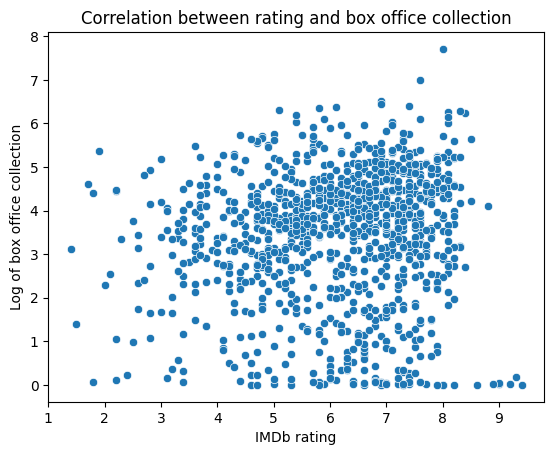

[[2.03761172 0.20694846]
 [0.20694846 2.26733228]]


In [9]:
import seaborn as sns
sns.scatterplot(x='rating', y=target_var, data=data)
plt.xlabel('IMDb rating')
plt.ylabel('Log of box office collection')
plt.title('Correlation between rating and box office collection')
plt.show()
print(np.cov(data['rating'], data[target_var]))

So, correlation between rating and box office collection is not very significant.

Movies released on <b>Special days</b> like Valentine's day tend to have higher box office collection. So let us parse holiday feature from the release day.

In [10]:
import holidays
from datetime import timedelta, date
TARGET_COUNTRY = 'IN'
years_range = range(1956, 2025)
country_holidays = holidays.country_holidays(TARGET_COUNTRY, years=years_range)
holiday_windows = {
    'Christmas': (7, 2), #7 days before and 2 days after
    'Republic Day': (4, 1),
    'Independece Day': (4, 1),
    'Gandhi Jayanti': (3, 1),
    'Buddha Purnima': (3, 1),
    'Diwali': (7, 2),
    'Janmashtami' : (3, 1),
    'Dussehra': (8, 2),
    'Mahavir Jayanti': (2, 1),
    'Maha Shivaratri': (2, 1),
    'Guru Nanak Jayanti': (2, 1),
    "Prophet's Birthday": (3, 1),
    'Eid al-Fitr': (4, 1),
    'Eid al-Adha': (4, 1),
    'Good Friday': (2, 1),
    'Valentines' : (3, 1)
}
relevant_holiday_dates = {}
for holiday_name in holiday_windows.keys():
    dates = [date for date, name in country_holidays.items() if holiday_name in name]
    relevant_holiday_dates[holiday_name] = dates

def check_holiday_proximity(release_date, holiday_name, window_days, all_holiday_dates):
    # Check if release_date is indeed a Timestamp before calling .date()
    if pd.isna(release_date): # Handle potential missing dates
        return 0
    try:
        # Extract the date part from the Timestamp
        release_date_obj = release_date.date()
    except AttributeError:
         # Handle cases where release_date might already be a date or different type
         if isinstance(release_date, date):
             release_date_obj = release_date
         else:
             print(f"Warning: Unexpected type for release_date: {type(release_date)}. Value: {release_date}")
             # Attempt conversion if possible, otherwise return 0
             try:
                 release_date_obj = pd.to_datetime(release_date).date()
             except Exception:
                 return 0 # Cannot process this date


    days_before, days_after = window_days
    # Get the specific holiday dates for this holiday name
    holiday_dates = all_holiday_dates.get(holiday_name, [])

    for holiday_date in holiday_dates: # holiday_date from the library is usually datetime.date
        # Calculate window boundaries (these will be datetime.date objects)
        start_window = holiday_date - timedelta(days=days_before)
        end_window = holiday_date + timedelta(days=days_after)

        # Now compare date objects (datetime.date vs datetime.date)
        if start_window <= release_date_obj <= end_window:
            return 1
    return 0

print("Creating holiday features...")
for holiday, window in holiday_windows.items():
    feature_name = f'is_{holiday.lower()}_period'
    if holiday == 'Valentines': # Manual handling example remains the same
        data[feature_name] = data['Release Date'].apply(
            lambda d: 1 if not pd.isna(d) and (d.month == 2) and (14 - window[0] <= d.day <= 14 + window[1]) else 0
        ).astype(int)
    elif holiday in relevant_holiday_dates: # Check using the holidays package
        data[feature_name] = data['Release Date'].apply(
            # Pass the function directly to apply
            lambda d: check_holiday_proximity(d, holiday, window, relevant_holiday_dates)
        ).astype(int)
    # Add more elif blocks for other manually handled dates if needed

print("Holiday features created.")

# Display counts for verification
for col in data.columns:
    if col.startswith('is_') and col.endswith('_period'):
        print(f"Count for {col}: {data[col].sum()}")

/usr/local/lib/python3.11/dist-packages/holidays/countries/india.py:180: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)


Creating holiday features...


<ipython-input-10-1a9c39f01a4f>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_name] = data['Release Date'].apply(
<ipython-input-10-1a9c39f01a4f>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_name] = data['Release Date'].apply(
<ipython-input-10-1a9c39f01a4f>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

Holiday features created.
Count for is_christmas_period: 37
Count for is_republic day_period: 28
Count for is_independece day_period: 0
Count for is_gandhi jayanti_period: 16
Count for is_buddha purnima_period: 6
Count for is_diwali_period: 39
Count for is_janmashtami_period: 12
Count for is_dussehra_period: 28
Count for is_mahavir jayanti_period: 8
Count for is_maha shivaratri_period: 10
Count for is_guru nanak jayanti_period: 10
Count for is_prophet's birthday_period: 16
Count for is_eid al-fitr_period: 30
Count for is_eid al-adha_period: 21
Count for is_good friday_period: 17
Count for is_valentines_period: 12


<ipython-input-10-1a9c39f01a4f>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_name] = data['Release Date'].apply(
<ipython-input-10-1a9c39f01a4f>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_name] = data['Release Date'].apply(


In [11]:
data['special_day'] = False
data['special_day'] |= (data['is_christmas_period']).astype(bool)
data['special_day'] |= (data['is_republic day_period']).astype(bool)
data['special_day'] |= (data['is_good friday_period']).astype(bool)
data['special_day'] |= (data['is_valentines_period']).astype(bool)
data['special_day'] |= (data['is_diwali_period']).astype(bool)
data['special_day'] |= (data['is_eid al-fitr_period']).astype(bool)
data['special_day'] |= (data['is_eid al-adha_period']).astype(bool)
data['special_day'] |= data['is_dussehra_period']

data['special_day'] = data['special_day'].astype(int)

<ipython-input-11-b1fcbbdc4b4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['special_day'] = False
<ipython-input-11-b1fcbbdc4b4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['special_day'] |= (data['is_christmas_period']).astype(bool)
<ipython-input-11-b1fcbbdc4b4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

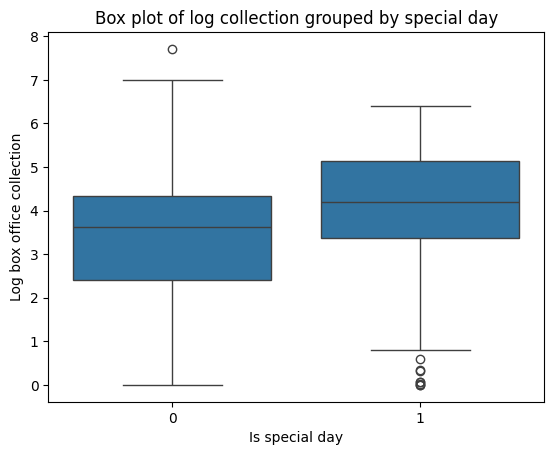

In [12]:
sns.boxplot(x='special_day', y=target_var, data=data)
plt.xlabel('Is special day')
plt.ylabel('Log box office collection')
plt.title('Box plot of log collection grouped by special day')
plt.show()

So, movies released on special days tend to have higher box office collection.

# 3. Data preprocessing

Here we will extract the features required to train the model. We will split genre, convert duration to minutes, and extract star score from director, actor and writers.

In [13]:
print("Creating genre columns")
Genres = ['Action', 'Crime', 'Music', 'Musical', 'Drama', 'Family', 'Comedy', 'Romance', 'Fantasy', 'Mystery', 'War', 'Biography', 'History', 'Thriller', 'Adventure', 'Horror', 'Animation', 'Sport', 'Sci-Fi', 'Documentary']
for genre in Genres:
    feature_name = f'is_{genre.lower()}'
    data[feature_name] = data['Genre'].apply(
        lambda d: 1 if not pd.isna(d) and genre in d.split('+') else 0
    ).astype(int)
print("Genre columns created")

Creating genre columns
Genre columns created


<ipython-input-13-216fc22dd4a9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_name] = data['Genre'].apply(
<ipython-input-13-216fc22dd4a9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_name] = data['Genre'].apply(
<ipython-input-13-216fc22dd4a9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [14]:
import re
def parse_duration(d):
    if pd.isna(d):
        return np.nan
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', d)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours * 60 + minutes
    return np.nan
data['duration_m'] = data['duration'].apply(parse_duration)
mean_duration = data['duration_m'].mean()
data['duration_m'].fillna(mean_duration, inplace=True)

<ipython-input-14-93fb4f75cf73>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duration_m'] = data['duration'].apply(parse_duration)
<ipython-input-14-93fb4f75cf73>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['duration_m'].fillna(mean_duration, inplace=True)
<ipython-

In [16]:
stars = [
    'Deepika Padukone',
    'Katrina Kaif',
    'Kareena Kapoor',
    'Madhuri Dixit',
    'Vidya Balan',
    'Shraddha Kapoor',
    'Sharmila Tagore',
    'Hema Malini',
    'Kajol',
    'Rani Mukerji',
    'Aishwarya Rai Bachchan',
    'Sonakshi Sinha',
    'Priyanka Chopra Jonas',
    'Kiara Advani',
    'Anushka Sharma',
    'Manisha Koirala',
    'Sridevi',
    'Alia Bhatt', #ending female actors here
    'Dilip Kumar',
    'Manoj Kumar',
    'Vyjayanthimala',
    'Amitabh Bachchan',
    'Shah Rukh Khan',
    'Saif Ali Khan',
    'Hrithik Roshan',
    'Aamir Khan',
    'Akshay Kumar',
    'Mithun Chakraborty',
    'Madhavan',
    'Ajay Devgn',
    'Salman Khan',
    'Ranveer Singh',
    'Sanjay Dutt',
    'Ranbir Kapoor',
    'Shahid Kapoor',
    'Vicky Kaushal',
    'Anil Kapoor',
    'Prabhas',
    'Ayushmann Khurrana',
    'Vijay Sethupathi',
    'Pankaj Tripathi', #ending male actors here
    'Rajkumar Hirani',
    'Karan Johar',
    'Rohit Shetty',
    'Sanjay Leela Bhansali',
    'Kabir Khan',
    'Siddharth Anand',
    'Yash Chopra',
    'Raj Kapoor', #ending directors here
    'K. Asif',
    'Salim Khan',
    'Javed Akhtar',
    'Aditya Chopra',
    'Kader Khan',
    'Honey Irani' #ending writers here
]
def parse_star_score(d):
    if pd.isna(d):
        return 0
    names = d.split('+')
    count = sum(1 for name in names if name in stars)
    return count

data['star_score'] = 0
data['star_score'] += data['director'].apply(parse_star_score)
data['star_score'] += data['actors'].apply(parse_star_score)
data['star_score'] += data['writers'].apply(parse_star_score)

data = data.drop(['director', 'actors', 'writers'], axis=1)

<ipython-input-16-8a878636867e>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['star_score'] = 0
<ipython-input-16-8a878636867e>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['star_score'] += data['director'].apply(parse_star_score)
<ipython-input-16-8a878636867e>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

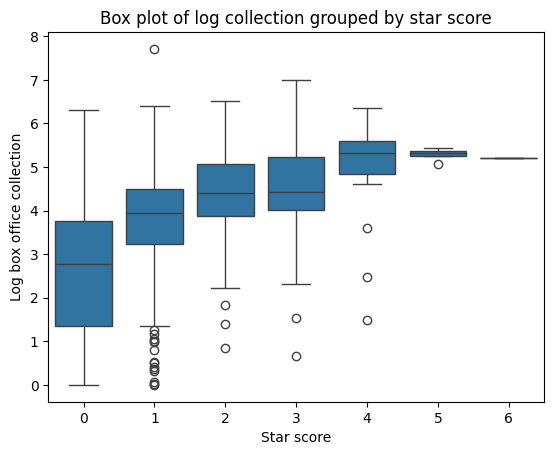

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='star_score', y=target_var, data=data)
plt.xlabel('Star score')
plt.ylabel('Log box office collection')
plt.title('Box plot of log collection grouped by star score')
plt.show()

So, higher star score has higher box office collection.

In [ ]:
data.to_csv('data_for_model.csv', index=False)

# 4. Predictive model

In [19]:
import pandas as pd
import numpy as np
df = pd.read_csv('data_for_model.csv')
X = df[['is_action','is_crime','is_music','is_drama','is_family','is_comedy','is_romance','is_fantasy','is_mystery','is_war','is_biography','is_history','is_thriller','is_adventure','is_horror','is_animation','is_sport','is_sci-fi','is_documentary', 'duration_m', 'rating', 'star_score', 'special_day']].to_numpy()
y = df['log_box_office'].to_numpy()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [22]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [23]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R2 = ", r2)

R2 =  0.42810973301892097


# 5. Conclusion

Generally R2 between 0.4 to 0.6 is considered good. Here, dataset is noisy, so 0.43 value isn't bad. Perhaps a better prediction could be made by analysing the plot summary of the movies using techniques like bag of words, or implementing better models like random forest.